In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pylab as plt
pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid', palette='Paired', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)
from IPython import display
from pandas.api.types import CategoricalDtype

In [2]:
### read the 00 random result
commuter_df = pd.read_csv("assignment_00_random.csv",index_col=0)
## for easier coding, only take Manhattan workers (dir==in)
commuter_df = commuter_df[commuter_df['COMMUTE_DIRECTION_MANHATTAN']=='in'].reset_index()
commuter_df = commuter_df[['PERWT',"ARRIVES_AT_WORK_HOUR","MODE_TRANSP_TO_WORK","DISTANCE_KM","HOMEOWNER_LABEL",\
                           'Rand Assignment']].rename({'Rand Assignment':'Random'},axis=1)
mode_dict = {'Auto, truck, or van':'AutoOccupants',
             'Long-distance train or commuter train':'CommuterRail',
             'Subway or elevated':'Subway',
             'Walked only':'Walk',
             'Taxicab':'Taxicab',
             'Other':'Other',
             'Bus':'Bus',
             'Bicycle':'Bicycle',
             'Light rail, streetcar, or trolley (Carro público in PR)':'Other',
             'Ferryboat':'Ferry',
             'Motorcycle':'Motorcycle',
             'Worked at home':'WFH',
            }
commuter_df["MODE_TRANSP_TO_WORK"] = commuter_df["MODE_TRANSP_TO_WORK"].replace(mode_dict)
print(commuter_df.shape)
commuter_df.head(3)

(23198, 6)


,PERWT,ARRIVES_AT_WORK_HOUR,MODE_TRANSP_TO_WORK,DISTANCE_KM,HOMEOWNER_LABEL,Random
0,23.0,9,AutoOccupants,170.50491,Rent,No option
1,48.0,8,AutoOccupants,170.50491,Rent,Motorcycle
2,54.0,8,AutoOccupants,170.50491,Rent,Motorcycle


In [3]:
electric_reference_table = pd.read_csv("electric_reference_table.csv")
subway_floor = int(electric_reference_table[electric_reference_table['TransMode']=='Subway']['Floor_kwh'])
CommuterRail_floor = int(electric_reference_table[electric_reference_table['TransMode']=='CommuterRail']['Floor_kwh'])
electric_reference_table

,TransMode,Floor_kwh,Multiplier,MultiplierUnit,MultiplierTarget,RELATED_KEY,How_to_link_with_Multiplier
0,AutoOccupants,NaN,0.213400,kwh/km,Total Distance,"DISTANCE_KM, PERWT",DISTANCE_KM*PERWT
1,Bus,NaN,1.761000,kwh/km,Total Distance,"DISTANCE_KM, PERWT",DISTANCE_KM*PERWT/20
2,Ferry,NaN,10.000000,kwh,Number of Trips,PERWT,PERWT/100
3,Escooter,NaN,0.046622,kwh/km,Total Distance,"DISTANCE_KM, PERWT",DISTANCE_KM*PERWT
4,Bicycle,NaN,0.042403,kwh/km,Total Distance,"DISTANCE_KM, PERWT",DISTANCE_KM*PERWT
5,Motorcycle,NaN,0.152297,kwh/km,Total Distance,"DISTANCE_KM, PERWT",DISTANCE_KM*PERWT
6,Subway,55240.0,0.502700,kwh,Number of Commuters,PERWT,PERWT
7,CommuterRail,9147.0,0.240000,kwh,Number of Commuters,PERWT,PERWT


In [4]:
def Electricity(row):
    if row['TransMode']=='AutoOccupants':  
        return row['DISTANCE_KM']*row['PERWT']
    elif row['TransMode']=='Bus':
        return row['DISTANCE_KM']*row['PERWT']/20
    elif row['TransMode']=='Ferry':
        return row['PERWT']/100
    elif row['TransMode']=='Escooter':
        return row['DISTANCE_KM']*row['PERWT']
    elif row['TransMode']=='Bicycle':
        return row['DISTANCE_KM']*row['PERWT']
    elif row['TransMode']=='Motorcycle':
        return row['DISTANCE_KM']*row['PERWT']
    elif row['TransMode']=='Subway':
        return row['PERWT']
    elif row['TransMode']=='CommuterRail':
        return row['PERWT']

def floor(row):
    if row['TransMode']=='Subway':
        return row['ElectricityDemand']+subway_floor
    elif row['TransMode']=='CommuterRail':
        return row['ElectricityDemand']+CommuterRail_floor 
    else:
        return row['ElectricityDemand']

mode_order = CategoricalDtype(['AutoOccupants',
                               'Bus',
                               'Ferry', 
                               'Subway', 
                               'CommuterRail', 
                               'Bicycle', 
                               'Escooter', 
                               'Motorcycle', 
                               # 'Taxicab', 'Walk', 'WFH', 'Other', 'No option'
                              ],ordered=True)

In [5]:
### 1: based on current mode choices
### agg is not neccessary
# current = commuter_df.groupby(by=["ARRIVES_AT_WORK_HOUR","MODE_TRANSP_TO_WORK","DISTANCE_KM"]).agg({"PERWT":"sum"})\
#                      .reset_index().rename({'MODE_TRANSP_TO_WORK':'TransMode'},axis=1)
current = commuter_df[["ARRIVES_AT_WORK_HOUR","MODE_TRANSP_TO_WORK","DISTANCE_KM","PERWT"]].rename({'MODE_TRANSP_TO_WORK':'TransMode'},axis=1)
current = current.merge(right=electric_reference_table[['TransMode','Multiplier']], on=["TransMode"], how='inner')
current['MultiplierTarget'] = current.apply(lambda row: Electricity(row), axis=1)
current['ElectricityDemand'] = current['MultiplierTarget']*current['Multiplier']
current

,ARRIVES_AT_WORK_HOUR,TransMode,DISTANCE_KM,PERWT,Multiplier,MultiplierTarget,ElectricityDemand
0,9,AutoOccupants,170.504910,23.0,0.213400,3921.612936,836.872201
1,8,AutoOccupants,170.504910,48.0,0.213400,8184.235692,1746.515897
2,8,AutoOccupants,170.504910,54.0,0.213400,9207.265154,1964.830384
3,14,AutoOccupants,170.504910,29.0,0.213400,4944.642397,1055.186688
4,9,AutoOccupants,170.504910,33.0,0.213400,5626.662038,1200.729679
...,...,...,...,...,...,...,...
20979,9,Motorcycle,13.588843,30.0,0.152297,407.665292,62.086201
20980,8,Motorcycle,8.783599,79.0,0.152297,693.904307,105.679544
20981,8,Motorcycle,12.259721,139.0,0.152297,1704.101165,259.529495
20982,9,Motorcycle,1.151278,249.0,0.152297,286.668340,43.658728


In [6]:
result_current = current.groupby(by=["ARRIVES_AT_WORK_HOUR","TransMode"]).agg({"ElectricityDemand":"sum"}).reset_index()
result_current['ElectricityDemand'] = result_current.apply(lambda row: floor(row), axis=1)
result_current['TransMode'] = result_current['TransMode'].astype(mode_order)
result_current

,ARRIVES_AT_WORK_HOUR,TransMode,ElectricityDemand
0,0,AutoOccupants,11731.065495
1,0,Bus,85.846658
2,0,CommuterRail,9171.480000
3,0,Subway,56909.466700
4,1,AutoOccupants,5505.331036
...,...,...,...
119,22,Subway,58228.551500
120,23,AutoOccupants,24816.097594
121,23,Bus,2225.492141
122,23,CommuterRail,9473.640000


In [7]:
### 2: based on random 00 test
### agg is not neccessary
# random = commuter_df.groupby(by=["ARRIVES_AT_WORK_HOUR","Random","DISTANCE_KM","HOMEOWNER_LABEL"]).agg({"PERWT":"sum"})\
#                      .reset_index().rename({'Random':'TransMode'},axis=1)
random = commuter_df[["ARRIVES_AT_WORK_HOUR","Random","DISTANCE_KM","PERWT"]].rename({'Random':'TransMode'},axis=1)
random = random.merge(right=electric_reference_table[['TransMode','Multiplier']], on=["TransMode"], how='inner')
random['MultiplierTarget'] = random.apply(lambda row: Electricity(row), axis=1)
random['ElectricityDemand'] = random['MultiplierTarget']*random['Multiplier']

result_random = random.groupby(by=["ARRIVES_AT_WORK_HOUR","TransMode"]).agg({"ElectricityDemand":"sum"}).reset_index()
result_random['ElectricityDemand'] = result_random.apply(lambda row: floor(row), axis=1)
result_random['TransMode'] = result_random['TransMode'].astype(mode_order)
result_random

,ARRIVES_AT_WORK_HOUR,TransMode,ElectricityDemand
0,0,AutoOccupants,45.494260
1,0,Bicycle,5815.663292
2,0,Escooter,152.613549
3,0,Motorcycle,13722.272269
4,0,Subway,67848.218700
...,...,...,...
146,23,AutoOccupants,1689.755530
147,23,Bicycle,2021.945726
148,23,CommuterRail,9216.840000
149,23,Motorcycle,7616.527028


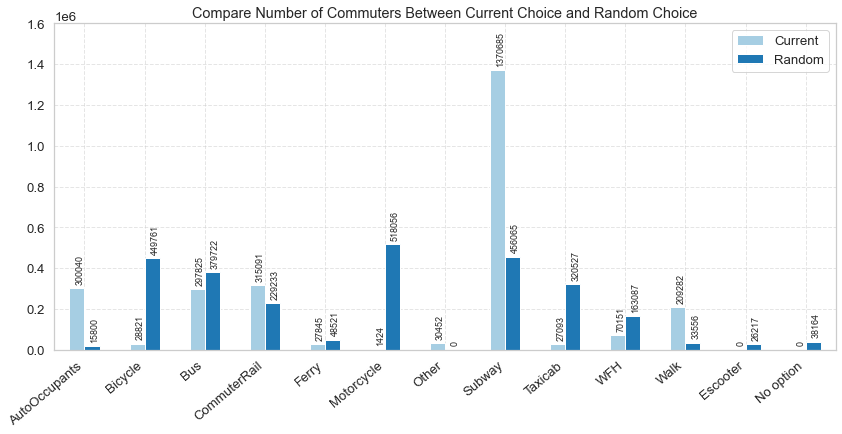

In [8]:
traffic_current = commuter_df.groupby(by=["MODE_TRANSP_TO_WORK"]).agg({"PERWT":"sum"}).reset_index().rename({'MODE_TRANSP_TO_WORK':'TransMode','PERWT':'Current'},axis=1)
traffic_random = commuter_df.groupby(by=["Random"]).agg({"PERWT":"sum"}).reset_index().rename({'Random':'TransMode','PERWT':'Random'},axis=1)
compare = traffic_current.merge(right=traffic_random, on=["TransMode"], how='outer')
compare
fig,(ax1) = plt.subplots(1,1)
plt.grid(ls='--',alpha=0.5)
compare.plot(kind='bar',ax=ax1,grid=True,legend=True,figsize=(14,6))
ax1.set_xticks(np.arange(len(compare)), compare['TransMode'].unique(),rotation=40, ha='right') 
for p in ax1.patches:
    ax1.annotate(int(p.get_height()), (p.get_x()+0.1, p.get_height()+30000),rotation=90,size=9)
ax1.set_ylim(0, 1600000)
plt.title("Compare Number of Commuters Between Current Choice and Random Choice")
plt.show()

#### Comment: A lot of motorcycle

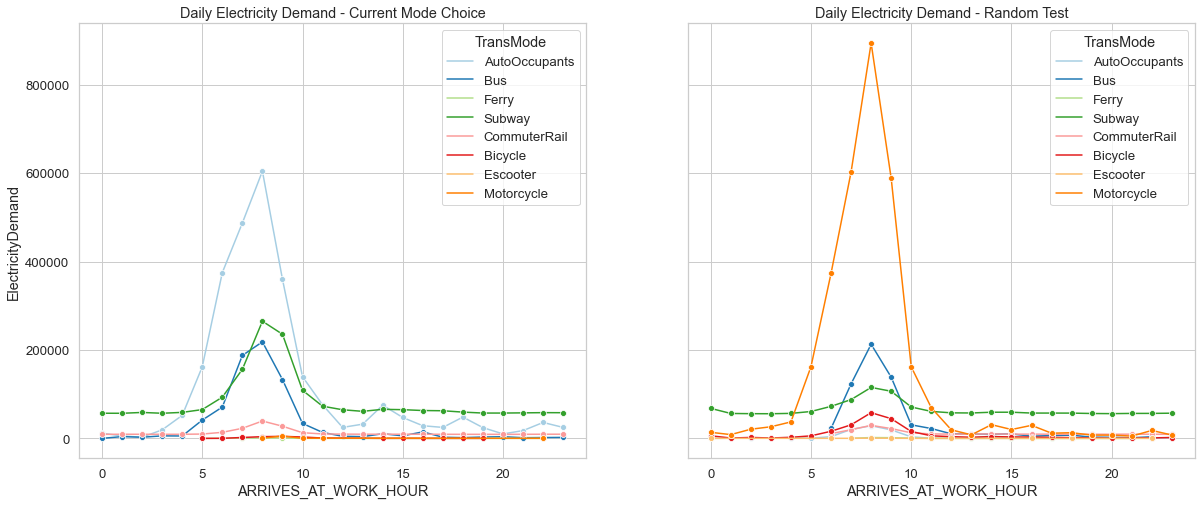

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,8),sharey=True)
ax1.grid(True),ax2.grid(True)
sns.lineplot(data=result_current,x='ARRIVES_AT_WORK_HOUR',y='ElectricityDemand',marker='o',hue='TransMode',ax=ax1)
ax1.set_title("Daily Electricity Demand - Current Mode Choice")
sns.lineplot(data=result_random,x='ARRIVES_AT_WORK_HOUR',y='ElectricityDemand',marker='o',hue='TransMode',ax=ax2)
ax2.set_title("Daily Electricity Demand - Random Test");

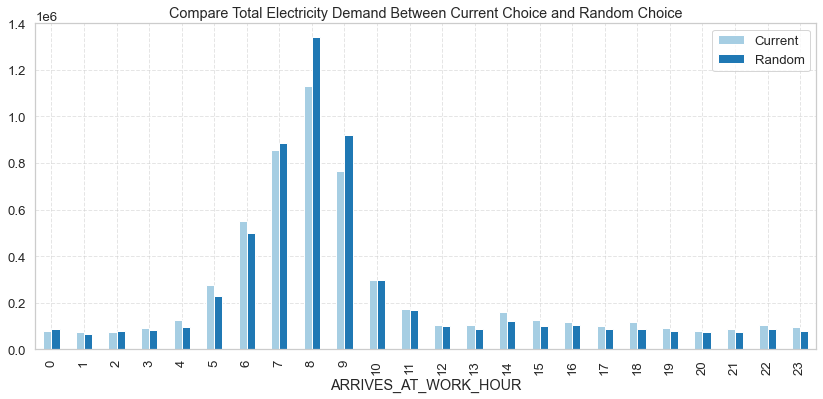

In [10]:
elec_current = result_current.groupby(by=["ARRIVES_AT_WORK_HOUR"]).agg({"ElectricityDemand":"sum"}).reset_index().rename({'ElectricityDemand':'Current'},axis=1)
elec_random = result_random.groupby(by=["ARRIVES_AT_WORK_HOUR"]).agg({"ElectricityDemand":"sum"}).reset_index().rename({'ElectricityDemand':'Random'},axis=1)
compare = elec_current.merge(right=elec_random, on=["ARRIVES_AT_WORK_HOUR"], how='outer').set_index('ARRIVES_AT_WORK_HOUR')
compare
fig,(ax1) = plt.subplots(1,1)
plt.grid(ls='--',alpha=0.5)
compare.plot(kind='bar',ax=ax1,grid=True,legend=True,figsize=(14,6))
ax1.set_ylim(0, 1400000)
plt.title("Compare Total Electricity Demand Between Current Choice and Random Choice")
plt.show()

### $$Factors & Assumptions - Upcoming Improvement$$
| Mode| Hour| No.Commuters| Distance | ResidentsYN | Charging Method  | Charging Speed  | Home_owner  |
| ---- | :----: | :----: | :----: | :----: | :----: | :----: | :----: |
|AutoOccupants  |   1   |   1   |   1   |   1   |       |   CAN   |       |
|Bus            |   1   |   1   |   1   |   1   |   1   |   CAN   |       |
|Ferry          |   1   |   1   |  CAN  |   1   |  CAN  |   CAN   |       |
|Subway         |   1   |   1   |       |   1   |       |         |       |
|CommuterRail   |   1   |   1   |       |   1   |       |         |       |
|Motorcycle     |   1   |   1   |   1   |   1   |       |   CAN   |       |
|Bicycle        |   1   |   1   |   1   |   1   |       |   CAN   |       |
|Escooter       |   1   |   1   |   1   |   1   |       |   CAN   |       |
|Taxicab        |   1   |   1   |   1   |   1   |       |   CAN   |       |
|Walk           |       |       |       |       |       |         |       |
|WFH            |       |       |       |       |       |         |       |

### Flow Simulation

In [11]:
### complete flow simulation
commuter_df = pd.read_csv("assignment_00_random.csv",index_col=0)
in_people = commuter_df[commuter_df['COMMUTE_DIRECTION_MANHATTAN']=='in'][['PERWT','HRS_WK_DAILY','ARRIVES_AT_WORK_HOUR']].reset_index(drop=True)
in_people['LEAVE_WORK_HOUR'] = (in_people['ARRIVES_AT_WORK_HOUR'] + in_people['HRS_WK_DAILY'])%24
in_people['LEAVE_WORK_HOUR'] = in_people['LEAVE_WORK_HOUR'].astype(int)
# in_people 

In [12]:
out_people = commuter_df[commuter_df['COMMUTE_DIRECTION_MANHATTAN']=='out'][['PERWT','HRS_WK_DAILY','ARRIVES_AT_WORK_HOUR']].reset_index(drop=True)
out_people['LEAVE_WORK_HOUR'] = (out_people['ARRIVES_AT_WORK_HOUR'] + out_people['HRS_WK_DAILY'])%24
out_people['LEAVE_WORK_HOUR'] = out_people['LEAVE_WORK_HOUR'].astype(int)
# out_people

In [13]:
in_flow_in = in_people[['PERWT','ARRIVES_AT_WORK_HOUR']].rename({'ARRIVES_AT_WORK_HOUR':'HOUR'},axis=1)
in_flow_out = out_people[['PERWT','LEAVE_WORK_HOUR']].rename({'LEAVE_WORK_HOUR':'HOUR'},axis=1)
in_flow = pd.concat([in_flow_in, in_flow_out], ignore_index=True)
# in_flow

In [14]:
out_flow_in = in_people[['PERWT','LEAVE_WORK_HOUR']].rename({'LEAVE_WORK_HOUR':'HOUR'},axis=1)
out_flow_out = out_people[['PERWT','ARRIVES_AT_WORK_HOUR']].rename({'ARRIVES_AT_WORK_HOUR':'HOUR'},axis=1)
out_flow = pd.concat([out_flow_in, out_flow_out], ignore_index=True)
# out_flow

In [15]:
in_flow = in_flow.groupby(by=["HOUR"]).agg({"PERWT":"sum"}).reset_index()
out_flow = out_flow.groupby(by=["HOUR"]).agg({"PERWT":"sum"}).reset_index()
# in_flow

Text(0.5, 1.0, "'Actual' Traffic Flow")

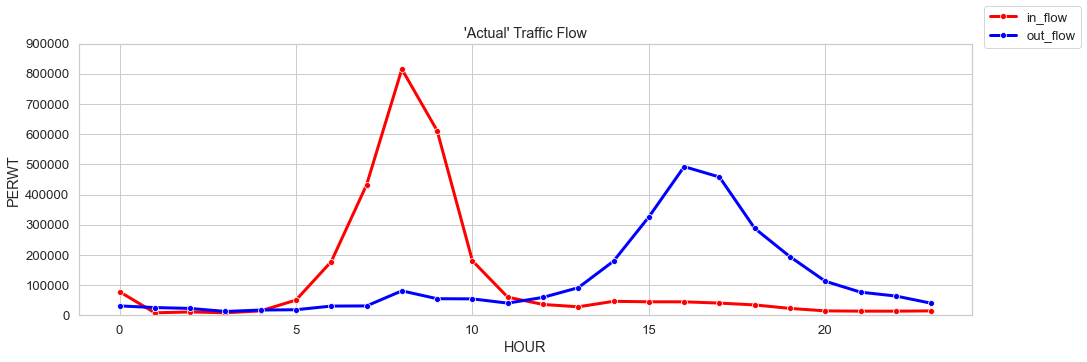

In [16]:
fig,(ax1)=plt.subplots(1,1,figsize=(16,5),sharey=True)
sns.lineplot(data=in_flow,x='HOUR',y='PERWT',marker='o',color='red',linewidth=3)
sns.lineplot(data=out_flow,x='HOUR',y='PERWT',marker='o',color='b',linewidth=3)
fig.legend(labels=['in_flow','out_flow'])
ax1.set_ylim(0, 900000)
ax1.set_title("'Actual' Traffic Flow")

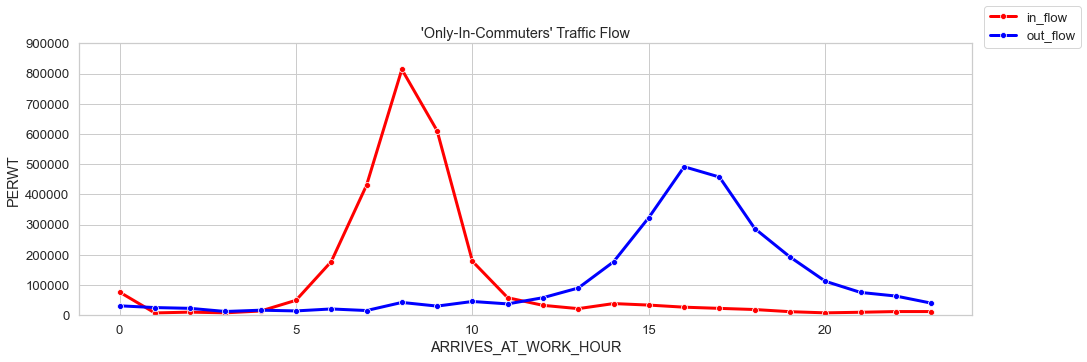

In [17]:
in_flow = in_people.groupby(by=["ARRIVES_AT_WORK_HOUR"]).agg({"PERWT":"sum"}).reset_index()
out_flow = in_people.groupby(by=["LEAVE_WORK_HOUR"]).agg({"PERWT":"sum"}).reset_index()
in_flow
fig,(ax1)=plt.subplots(1,1,figsize=(16,5),sharey=True)
sns.lineplot(data=in_flow,x='ARRIVES_AT_WORK_HOUR',y='PERWT',marker='o',color='red',linewidth=3)
sns.lineplot(data=out_flow,x='LEAVE_WORK_HOUR',y='PERWT',marker='o',color='b',linewidth=3)
fig.legend(labels=['in_flow','out_flow'])
ax1.set_ylim(0, 900000)
ax1.set_title("'Only-In-Commuters' Traffic Flow");

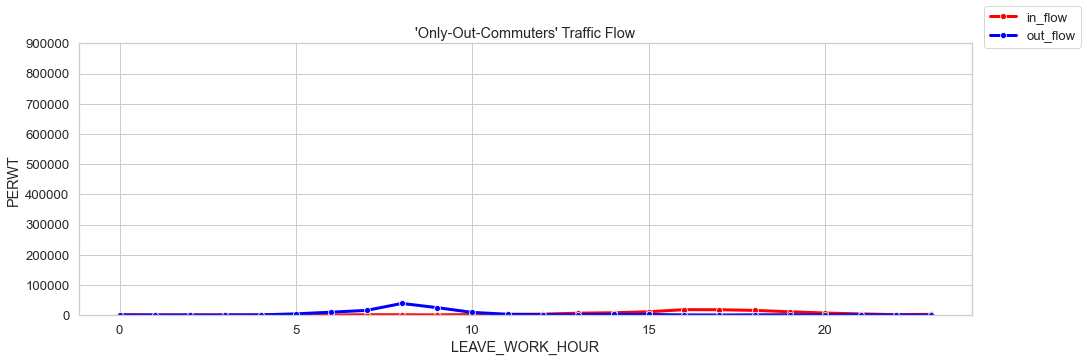

In [18]:
in_flow = out_people.groupby(by=["LEAVE_WORK_HOUR"]).agg({"PERWT":"sum"}).reset_index()
out_flow = out_people.groupby(by=["ARRIVES_AT_WORK_HOUR"]).agg({"PERWT":"sum"}).reset_index()
in_flow
fig,(ax1)=plt.subplots(1,1,figsize=(16,5),sharey=True)
sns.lineplot(data=in_flow,x='LEAVE_WORK_HOUR',y='PERWT',marker='o',color='red',linewidth=3)
sns.lineplot(data=out_flow,x='ARRIVES_AT_WORK_HOUR',y='PERWT',marker='o',color='b',linewidth=3)
fig.legend(labels=['in_flow','out_flow'])
ax1.set_ylim(0, 900000)
ax1.set_title("'Only-Out-Commuters' Traffic Flow");